In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import json
import geopandas as gpd
import unidecode
import osmnx as ox
import matplotlib as mpl
import os

plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

In [2]:
shapefile = gpd.read_file('/home/thmegy/Téléchargements/JRC_GRID_2018/JRC_POPULATION_2018.shp')

<AxesSubplot:>

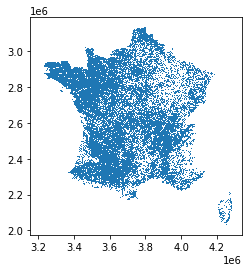

In [5]:
shapefile[shapefile['Country'] == 'FR'].plot()

In [266]:
dico_communes = json.load(open('input/dico_communes_insee.json', 'r'))

/tmp/ipykernel_38817/4051827009.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='input/dico_communes_insee.json' mode='r' encoding='UTF-8'>
  dico_communes = json.load(open('input/dico_communes_insee.json', 'r'))


In [359]:
communes = [
     'Clermont-Ferrand',
#      'Aulnat',
      'Aubière',
#       'Cébazat',
       'Chamalières',
       'Beaumont, Puy-de-dome',
#       'Cournon d\'Auvergne',
#       'Royat',
#       'Le Cendre',
#       'Orcines',
#       'Lempdes',
#       'Pont-du-chateau',
#       'Durtol',
#       'Nohanent',
#       'Blanzat',
#       'Châteaugay',
#       'Gerzat',
#       'Romagnat',
#       'Pérignat-lès-Sarliève',
#       'Saint-Gènes-Champanelle',
#       'Ceyrat'
]

communes_insee = [dico_communes[unidecode.unidecode(c.split(',')[0]).upper()] for c in communes]

limites = ox.geocode_to_gdf(communes)
limites.to_crs(crs=3035, inplace=True)

In [360]:
routes_main = gpd.GeoDataFrame()
routes_other = gpd.GeoDataFrame()

for com, insee in zip(communes, communes_insee):
    print(com, insee)
    filename = f'input/routes/{insee}'
    if os.path.isfile(filename):
        r_main = gpd.read_file(f'{filename}_main.geojson')
        r_main.to_crs(crs=3035, inplace=True)
        
        r_other = gpd.read_file(f'{filename}_other.geojson')
        r_other.to_crs(crs=3035, inplace=True)
        
    else:
        r = ox.geometries_from_place(com, tags={'highway':True})
        mask_main = r.highway.isin(['primary', 'primary_link', 'secondary', 'secondary_link', 'motorway'])
        mask_other = r.highway.isin(['pedestrian', 'tertiary', 'tertiary_link', 'residential'])
        r_main = r[['geometry']][mask_main]
        r_main.to_file(f'{filename}_main.geojson')
        r_main.to_crs(crs=3035, inplace=True)
        
        r_other = r[['geometry']][mask_other]
        r_other.to_file(f'{filename}_other.geojson')
        r_other.to_crs(crs=3035, inplace=True)
        
    routes_main = routes_main.append(r_main)
    routes_other = routes_other.append(r_other)

Clermont-Ferrand 63113
Aubière 63014
Chamalières 63075
Beaumont, Puy-de-dome 63032


In [361]:
shapefile_clipped = gpd.clip(shapefile, limites)

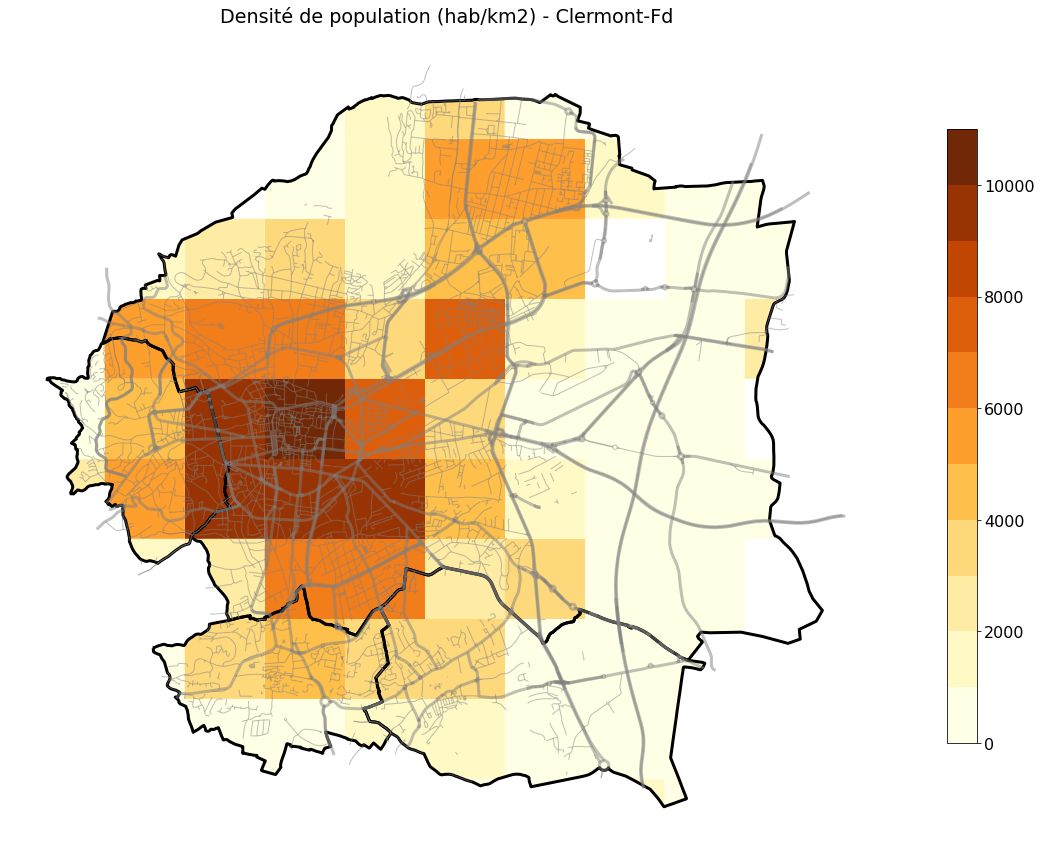

In [362]:
bounds = np.linspace(0, 11000, 12)
norm = mpl.colors.BoundaryNorm(bounds, 250)

ax = shapefile_clipped.plot(cmap='YlOrBr', norm=norm, column=shapefile_clipped['TOT_P_2018'],
                            legend=True, figsize=(22,15), legend_kwds={'fraction':0.025})
limites.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=3)
routes_main.plot(ax=ax, color='gray', alpha=0.5, linewidth=3)
routes_other.plot(ax=ax, color='gray', alpha=0.5, linewidth=1)

ax.set_title('Densité de population (hab/km2) - Clermont-Fd')
plt.axis('off')
#plt.savefig('density_metro.jpg', dpi=300)
plt.savefig('density_clermont.jpg', dpi=150)
plt.show()


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5f00953580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5f00953fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5f00996130>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5f00975a30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5f00975ee0>],
 'means': []}

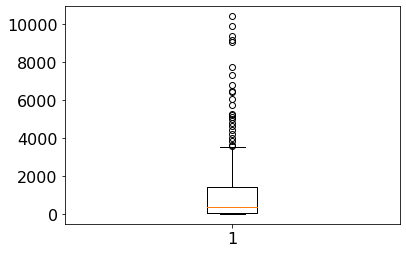

In [254]:
plt.boxplot(shapefile_clipped['TOT_P_2018'])

(array([211.,  29.,  16.,  11.,   6.,   4.,   4.,   2.,   0.,   4.,   1.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000., 11000.]),
 <BarContainer object of 11 artists>)

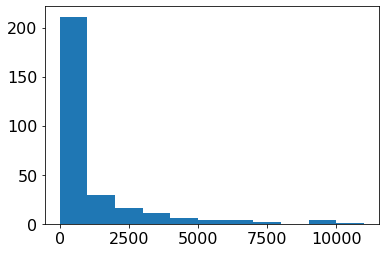

In [353]:
plt.hist(shapefile_clipped['TOT_P_2018'], bins=bounds)